<h1>Predicting Smoker Status Based on BioSignals</h1>

<h2> 1. Library Imports </h2>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer, MinMaxScaler, OneHotEncoder
import random

<h2>2. Data Exploration</h2>

<h3> 2.1 Exploratory Overview</h3>

In [ ]:
train = pd.read_csv('sample_data/train.csv')
test = pd.read_csv('sample_data/test.csv')


In [ ]:
train.shape, test.shape

((159256, 24), (106171, 23))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

<h3>2.2 Missing Values </h3>

In [ ]:
train[train.isnull().values.any(axis=1)]

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking


In [ ]:
train = train[~train.isnull().values.any(axis=1)]
train.shape

(159256, 24)

<h3> 2.2 Univariate Data Analysis </h3>

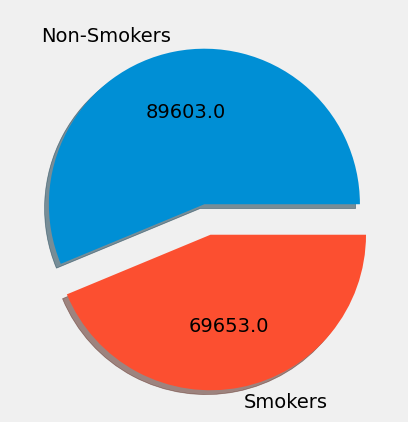

In [ ]:
train_target = train["smoking"].value_counts()

def absolute_value(val):
    a  = np.round(val/100.*train_target.sum(), 0)
    return a

mylabels = ["Non-Smokers", "Smokers"]
plt.style.use('fivethirtyeight')
myexplode = [0, 0.2]
plt.pie(train_target, labels= mylabels, explode=myexplode, shadow=True,
        autopct=absolute_value)
plt.show()

In [ ]:
pd.concat([train, test], axis='rows').describe(include='all').\
style.background_gradient(axis=1)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,265427.000000,159256.000000
mean,132713.000000,44.354591,165.248686,67.136444,83.001151,1.005389,1.000387,1.024071,1.023645,122.492350,76.852713,98.370708,195.827455,127.532109,55.880525,114.603571,14.795521,1.073659,0.892644,25.533958,26.556349,36.164358,0.196981,0.437365
std,76622.319288,11.864380,8.826224,12.586326,8.953381,0.400349,0.389693,0.153269,0.151941,12.743802,9.004327,15.332993,28.412319,66.254392,13.978732,27.679074,1.432445,0.345058,0.179578,9.480731,17.829734,31.094341,0.397718,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,46.000000,66.000000,8.000000,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,66356.500000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000,175.000000,77.000000,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,132713.000000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000,196.000000,115.000000,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,199069.500000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000,217.000000,165.000000,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,265426.000000,85.000000,190.000000,130.000000,127.700000,9.900000,9.900000,2.000000,2.000000,213.000000,140.000000,423.000000,393.000000,766.000000,148.000000,1860.000000,21.100000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


Some Notable Insights;


*   Values like: [AST, ALT, GTP, LDL, triglyceride] have high variations after the 75% mark, less prounonced features with the same issue include systolic, fasting blood sugar and cholesterol (240 is the most dangerous value for cholesterol I found online)
- HDL 9 : 25%
- LDL 1: 25% ???
- serum creatinine is also problematic
- urine protein as well
- Standard dev is also high for these variables
- hemoglobin differs signifcantly from max to thrird quartile


<b>2.3 Outlier Analysis and Handling</b>

In [ ]:
train.shape

(159256, 24)

In [ ]:
outlier_cols = ["Gtp", "AST", "ALT", "LDL", "triglyceride", "systolic",
                "fasting blood sugar","Cholesterol", "HDL", 'relaxation',
                'hemoglobin', "eyesight(right)","eyesight(left)", 'serum creatinine']
for col in outlier_cols:
  q1 = train[col].quantile(0.25)
  q3 = train[col].quantile(0.75)

  iqr = q3 - q1
  thresh = 1.5

  outs = train[(train[col] < (q1 - thresh * iqr)) | (train[col] >
   (q3 + thresh * iqr))]

  train.drop(outs.index, inplace=True)


In [ ]:
train.tail()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
159250,159250,25,180,90,88.0,1.5,1.2,1,1,119,...,43,123,15.3,1,1.1,24,29,42,1,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1
159255,159255,40,145,45,76.4,1.0,1.2,1,1,125,...,87,81,14.0,1,0.8,21,16,17,0,0


In [ ]:
train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

In [ ]:
def plot_hist(train, n_rows, n_cols):
  features = train.columns
  fig, ax = plt.subplots(n_rows,n_cols, figsize=(20,20))
  fig.tight_layout(pad=5.0)

  for index, value in enumerate(features):
    ax[index // n_cols][index % n_cols].set_xlabel(value)
    ax[index // n_cols][index % n_cols].hist(x= train[value], bins=10)
  plt.show()

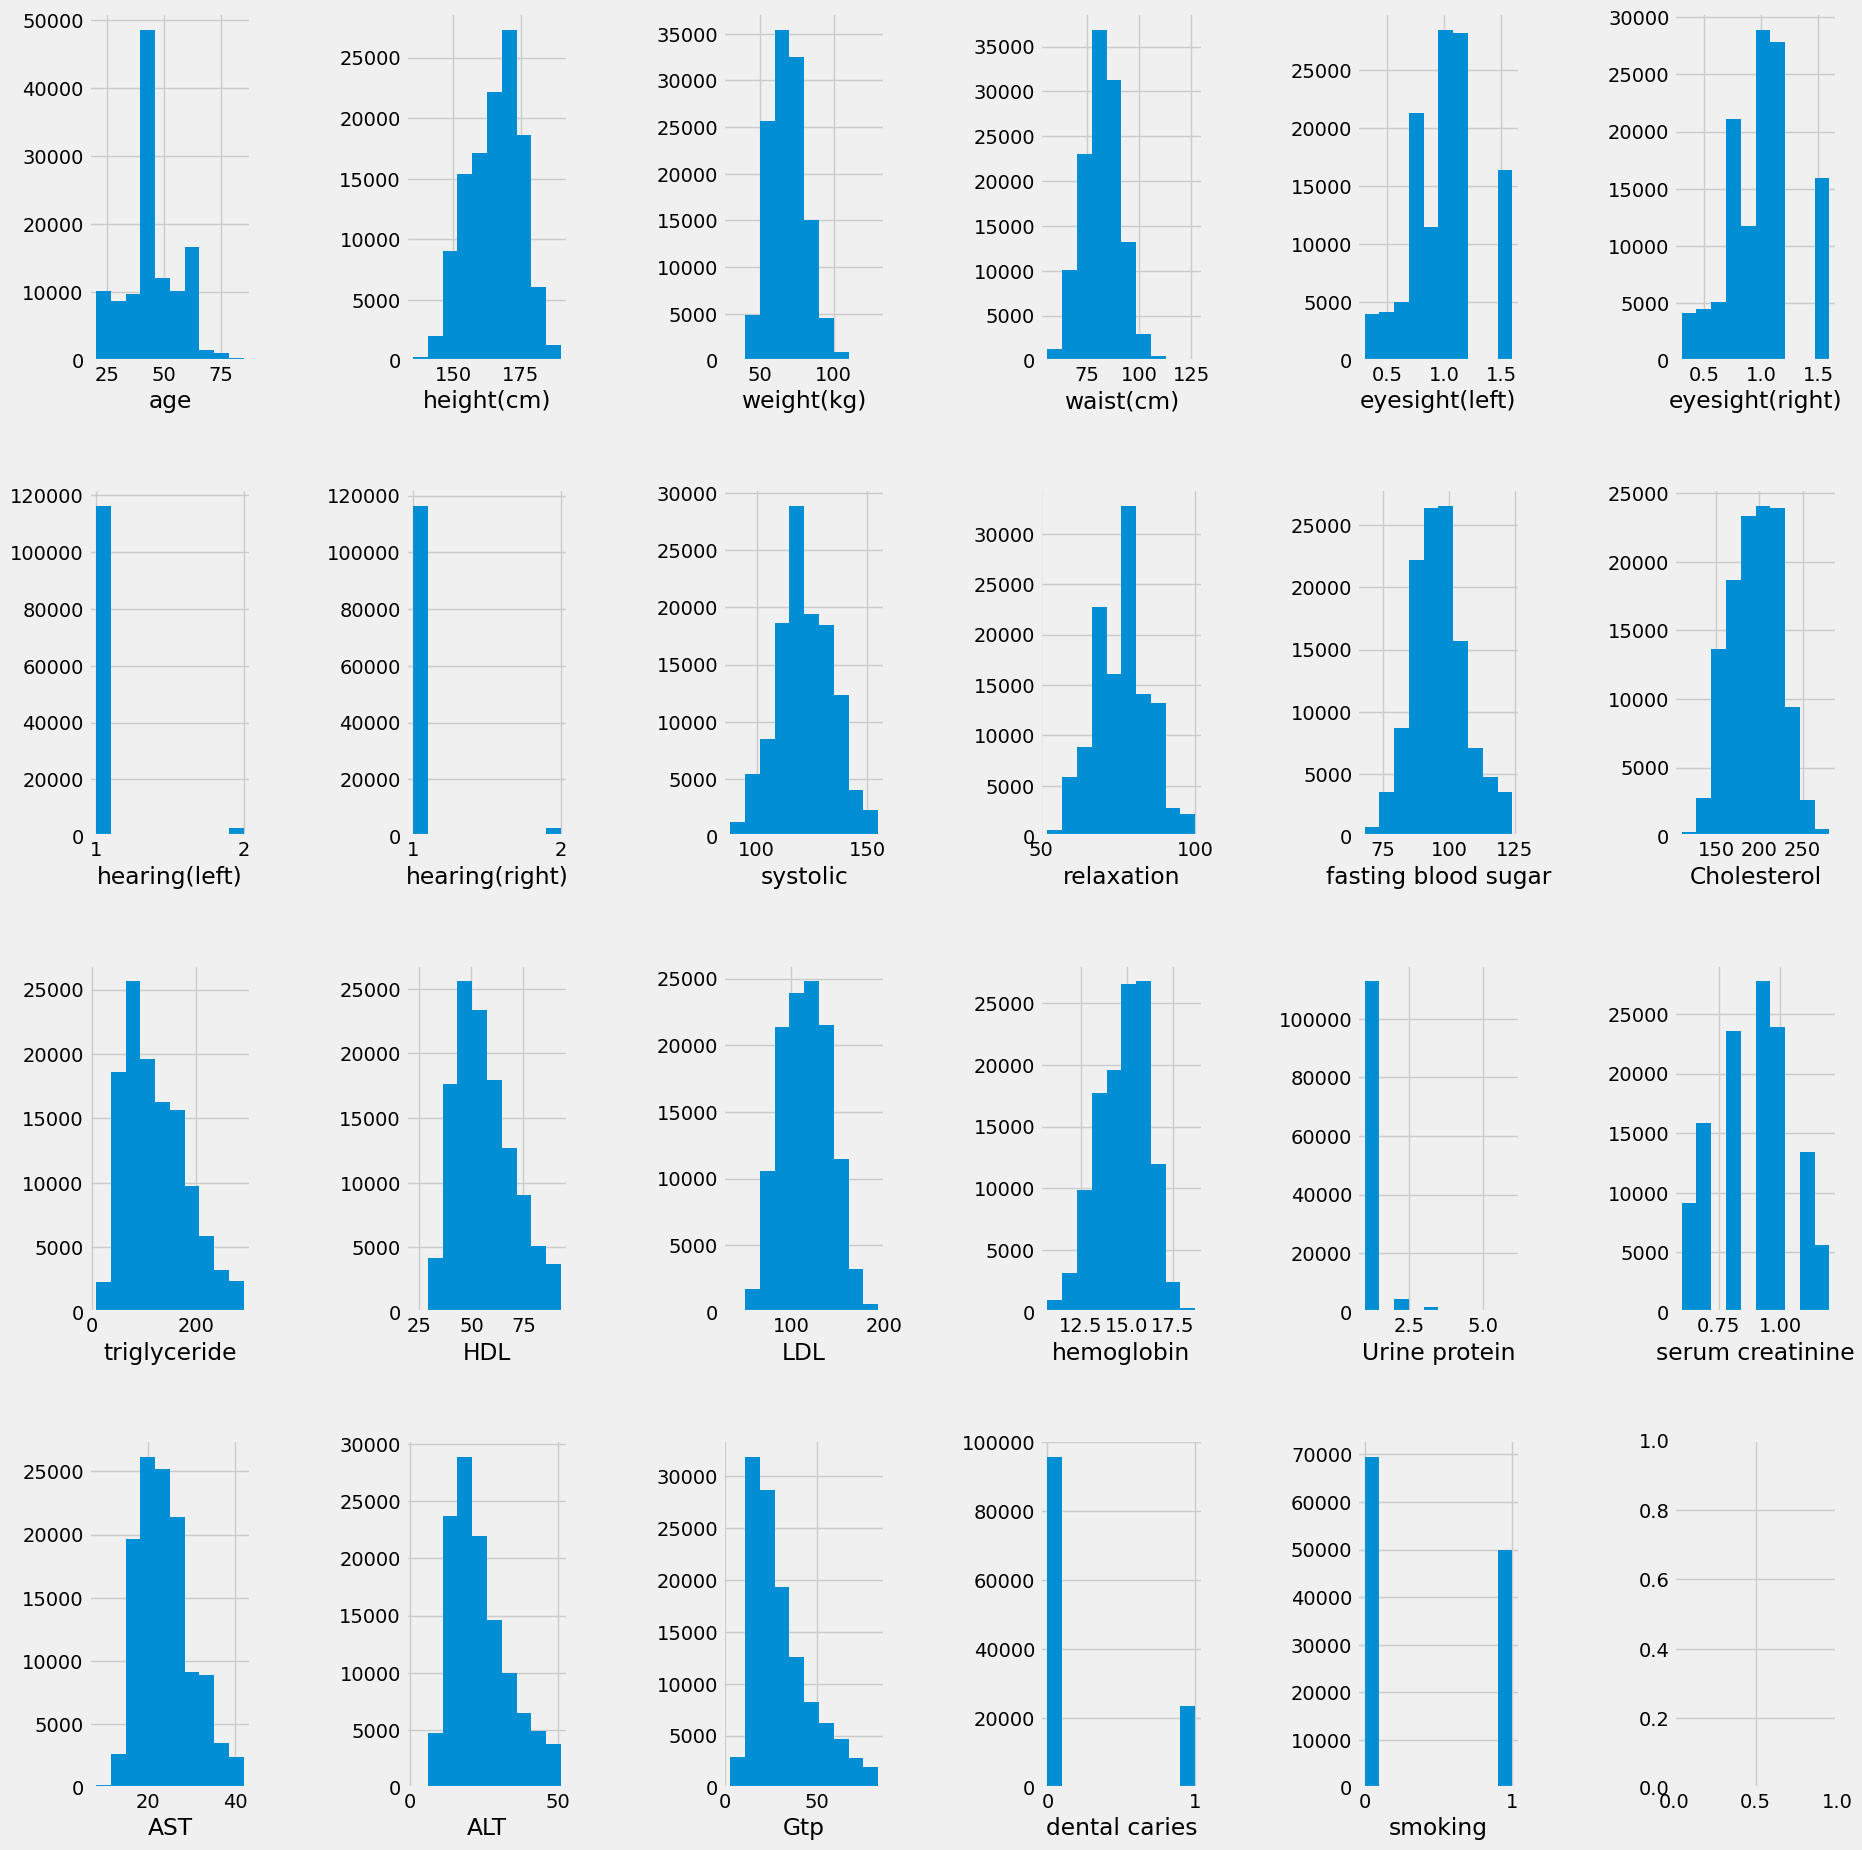

In [ ]:
plot_hist(train,4,6)

Notable Insights:

*  Seeing a lot of feautres with normal-like skewed disribution, power transform is an option



In [ ]:
def data_boxplot(train):
  fig, axes = plt.subplots(6,4, figsize=(20,20))
  fig.tight_layout(pad=5.0)

  plot_cols = train.columns

  for index, value in enumerate(plot_cols):
    sns.boxplot(ax= axes[index//4][index%4], y=train[value], x=train["smoking"])

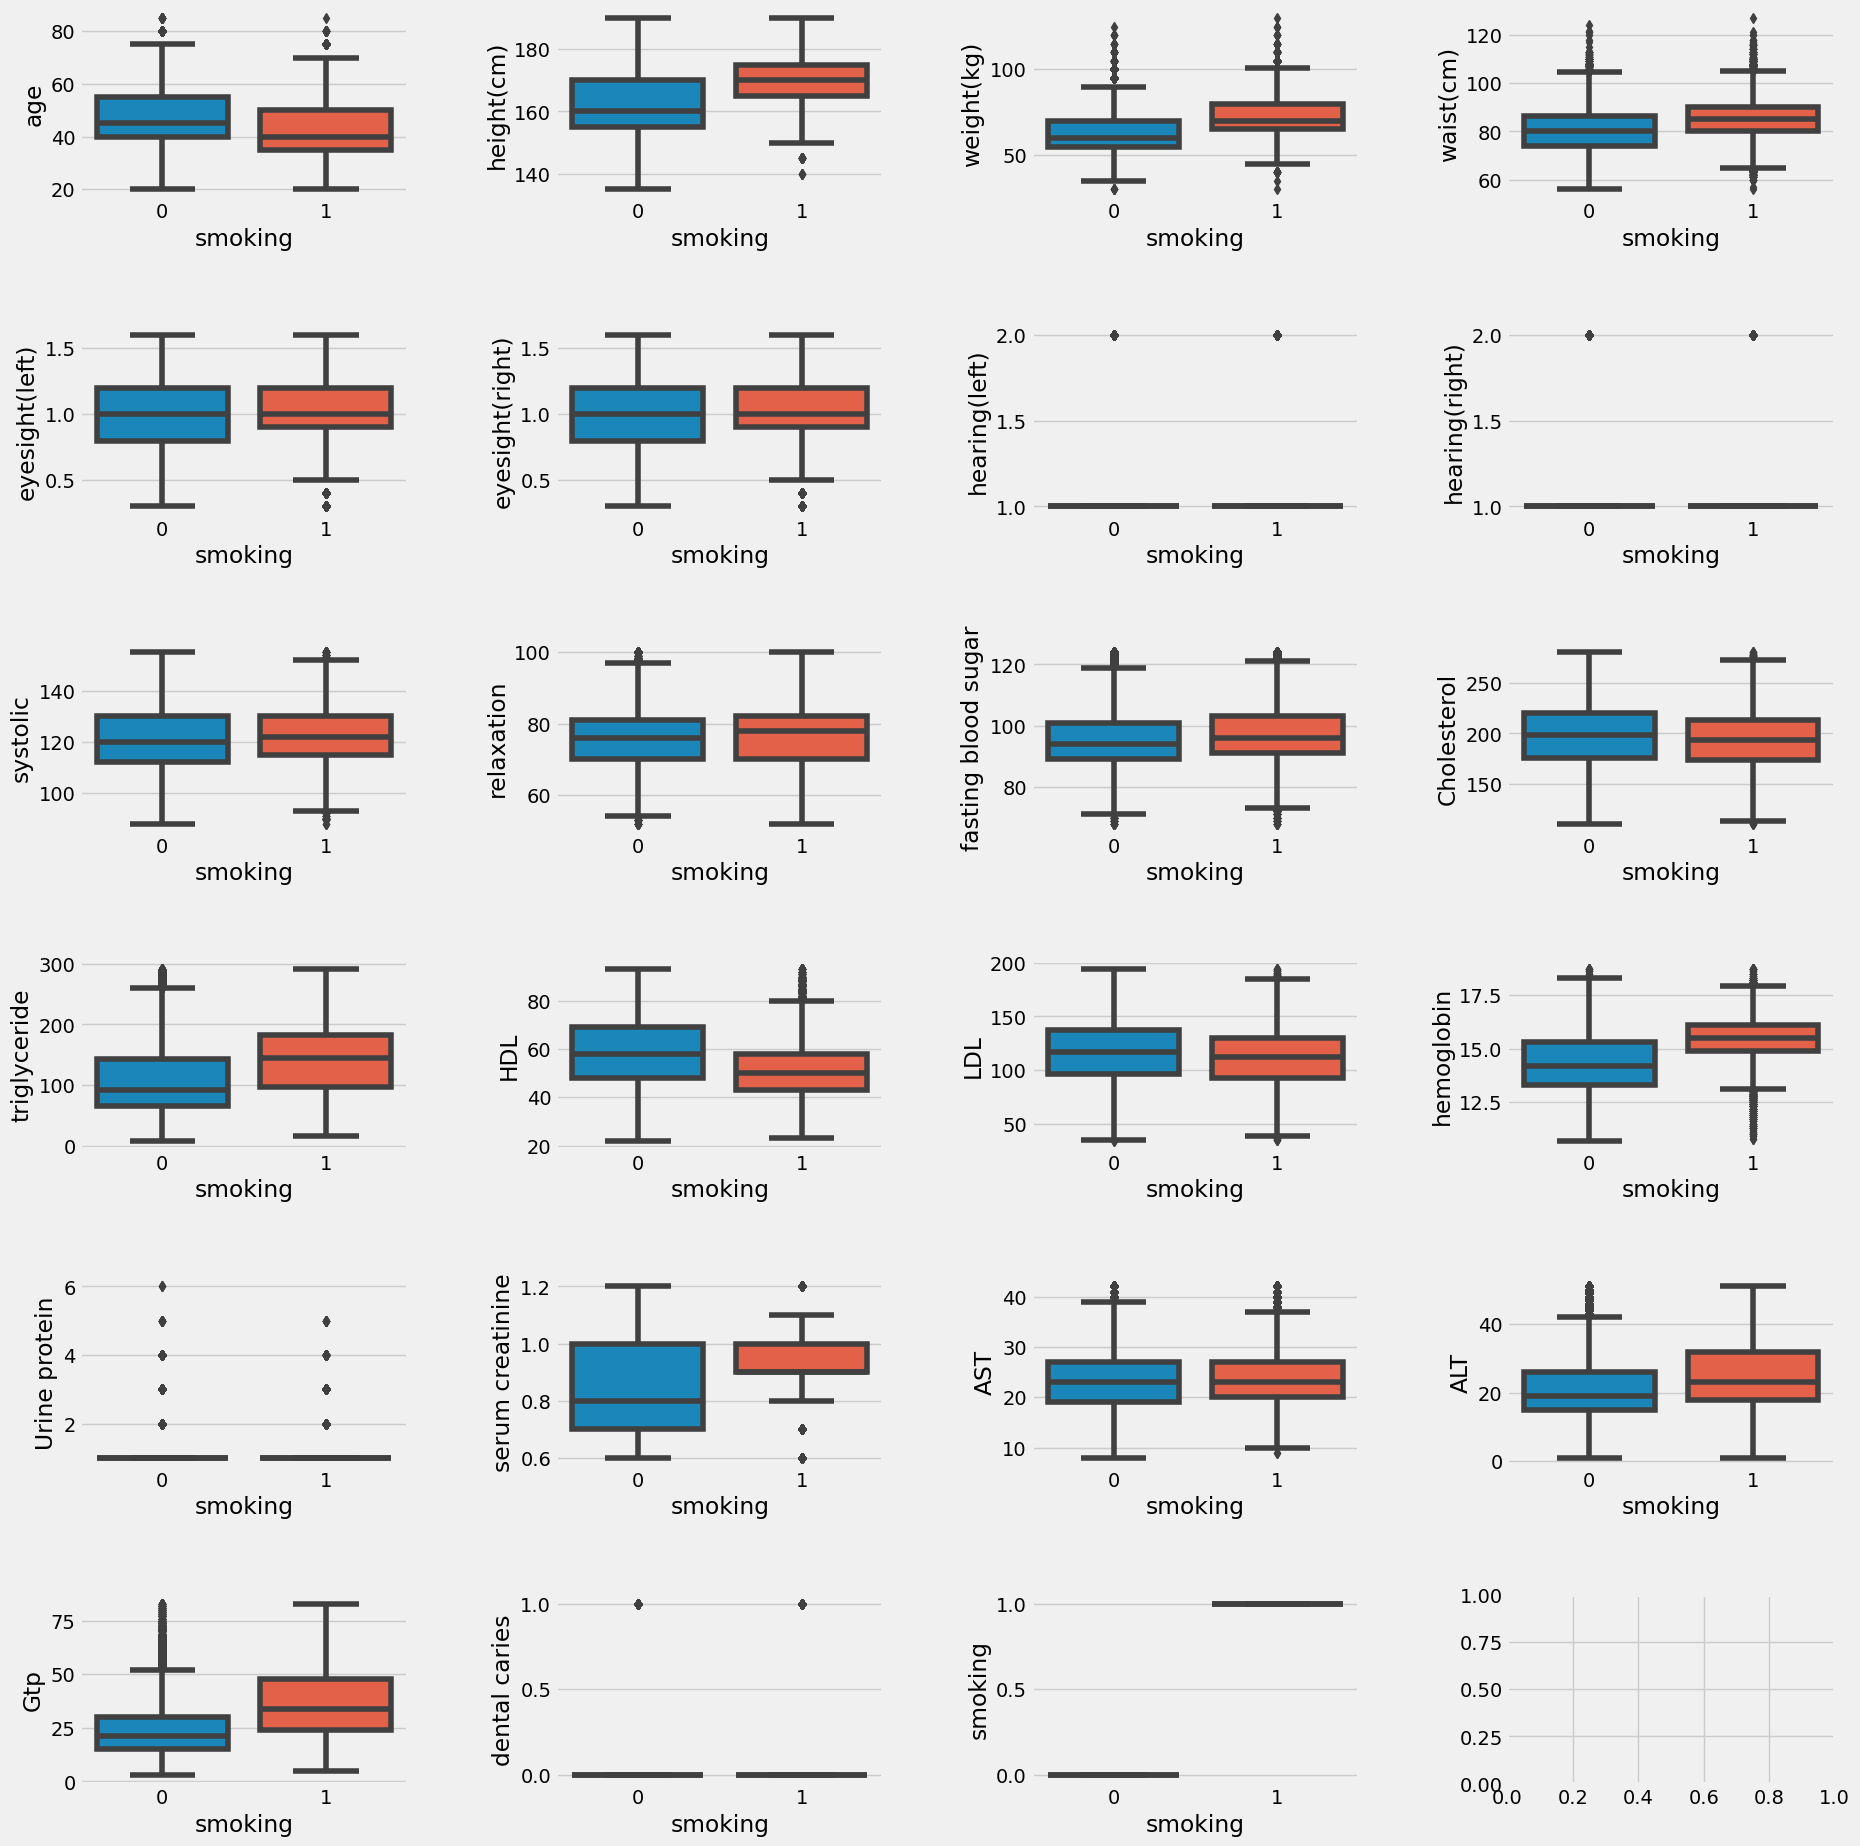

In [ ]:
data_boxplot(train)

Some Notable Insights:

*   Smokers tend to weigh more, have larger waists, and be taller (possible gender relationship)
*   Smokers tend to be younger
* smokers have higher levels of GTP on average
*   are those outliers in the eyesight features or just representive but distant points
- Serum creatinine levels of 5-10 also seem like outlier that need to be dealt with




<h3> 2.3 Multivariate Data Analysis </h3>

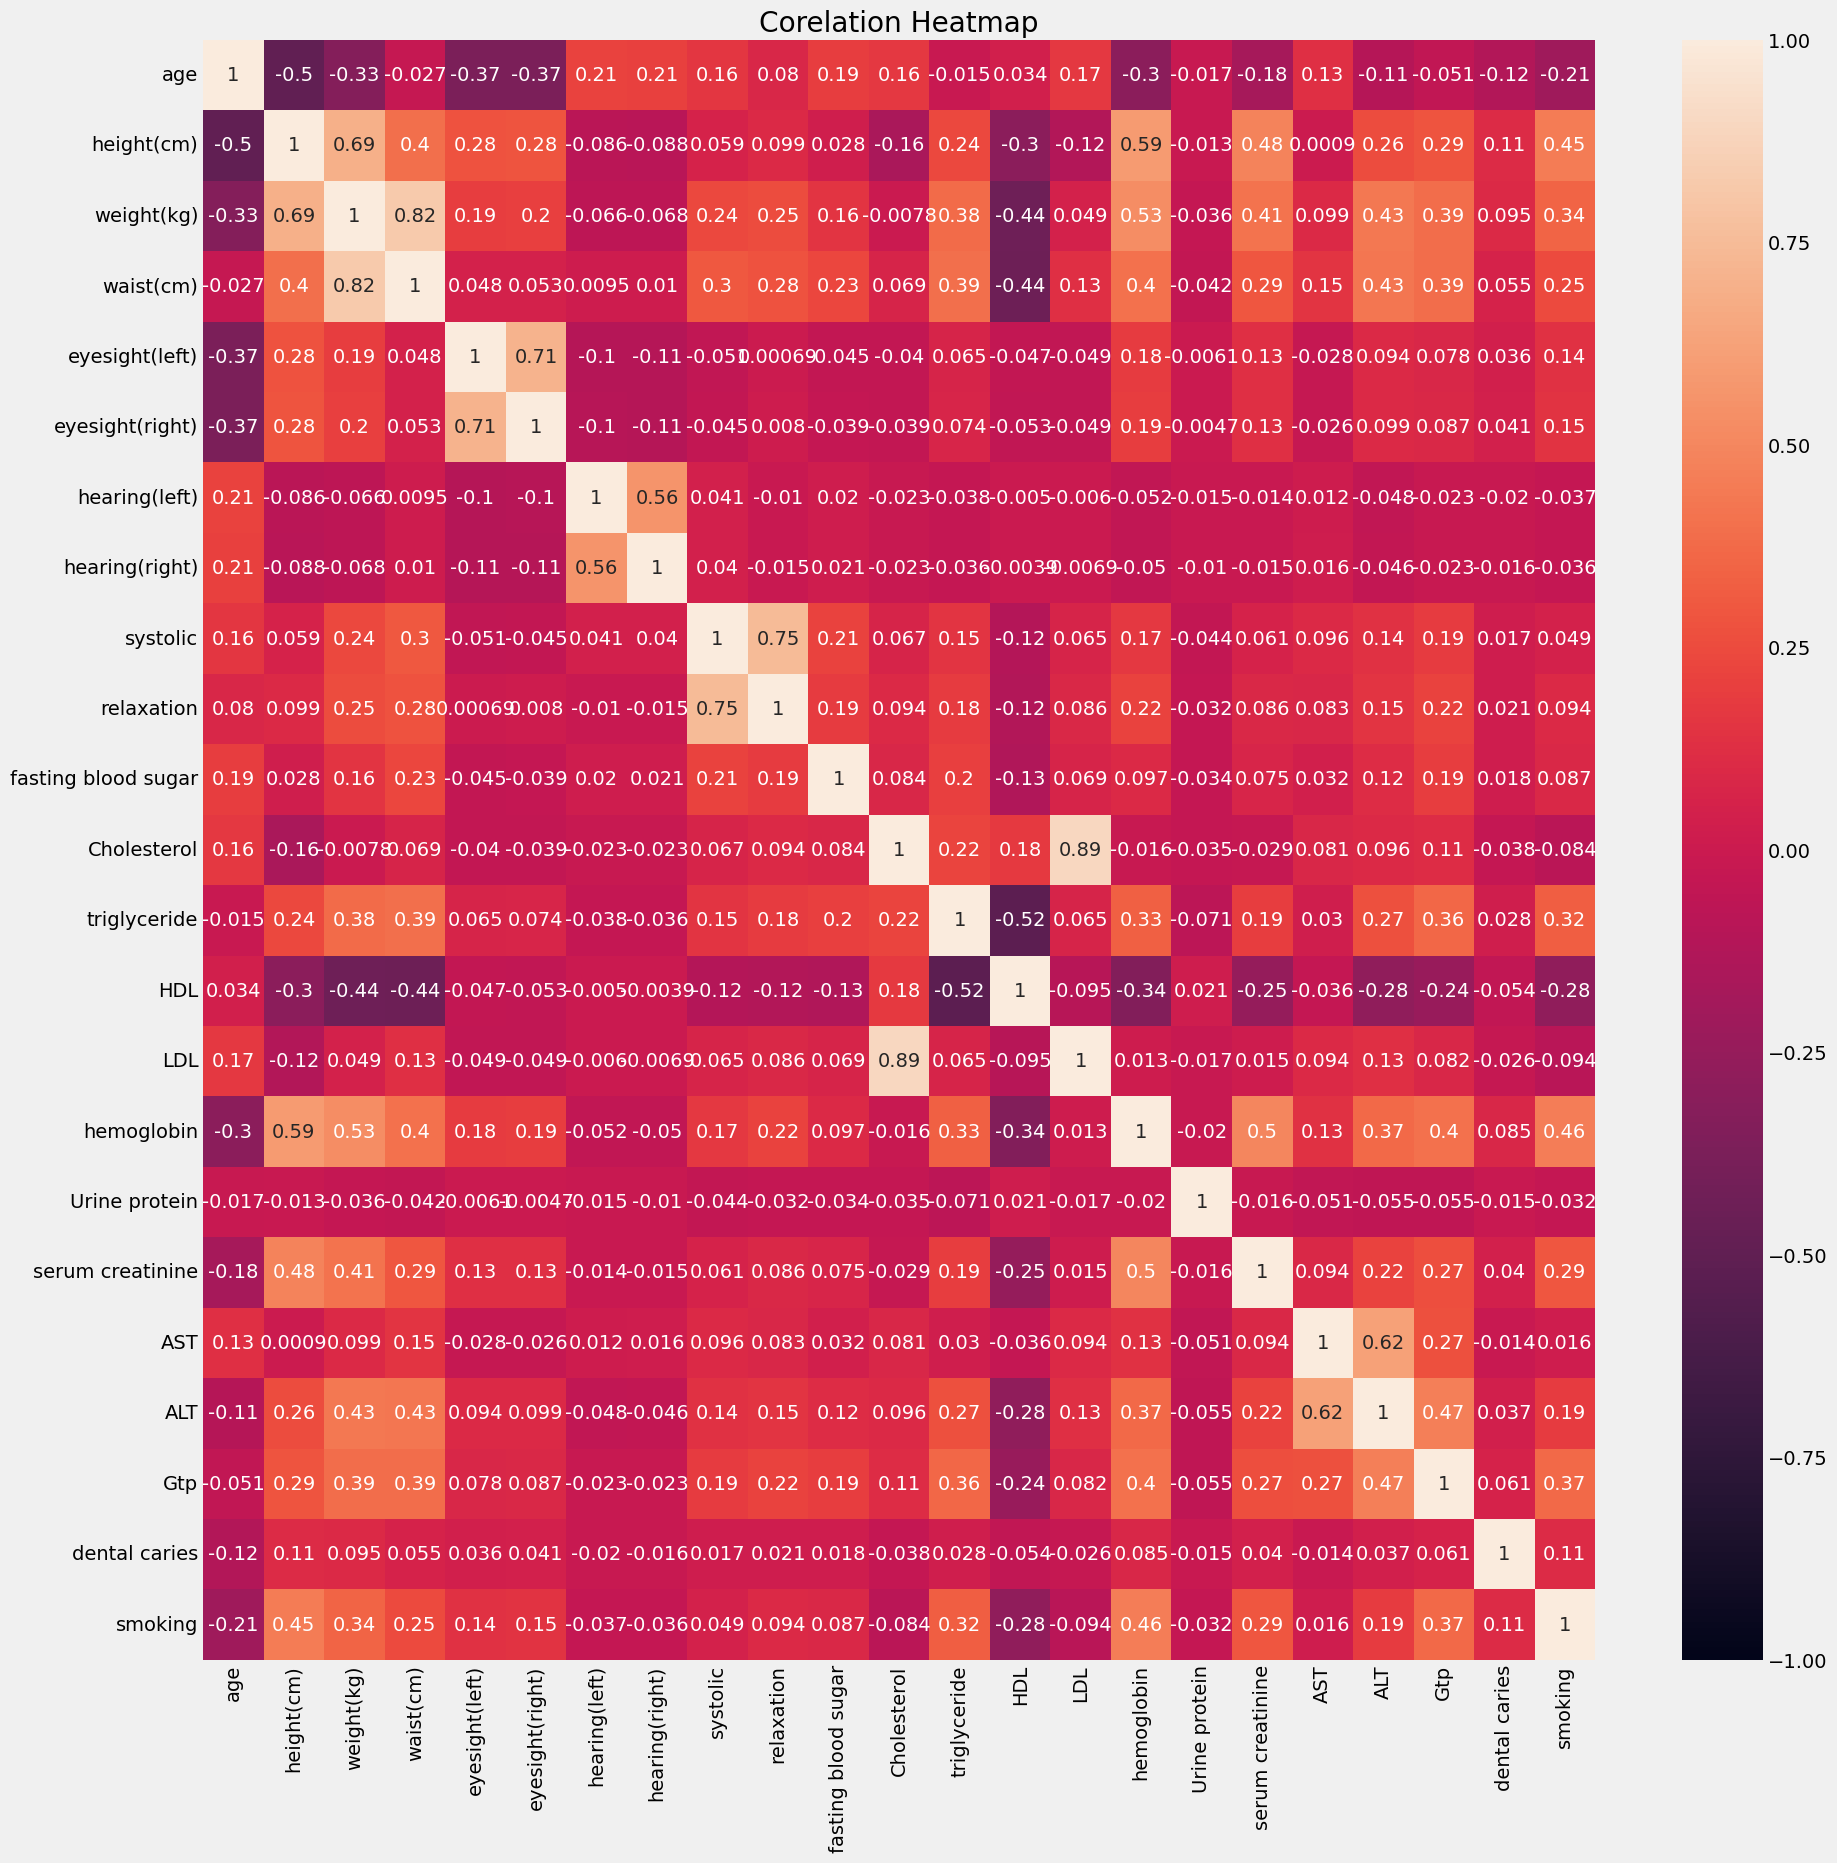

In [ ]:
plt.figure(figsize=(20,20))
plt.title("Corelation Heatmap")
sns.heatmap((train.corr()), annot=True, vmin=-1, vmax=1)
plt.show()

Some Notable Inisights:

*   Cholesterol and LDL are highly linked, same for AST/ALT, weight/waist, weight/height, relaxation/systolic
*  The three most directly corelated variabled with smoking are: height, Gtp, and hemoglobin



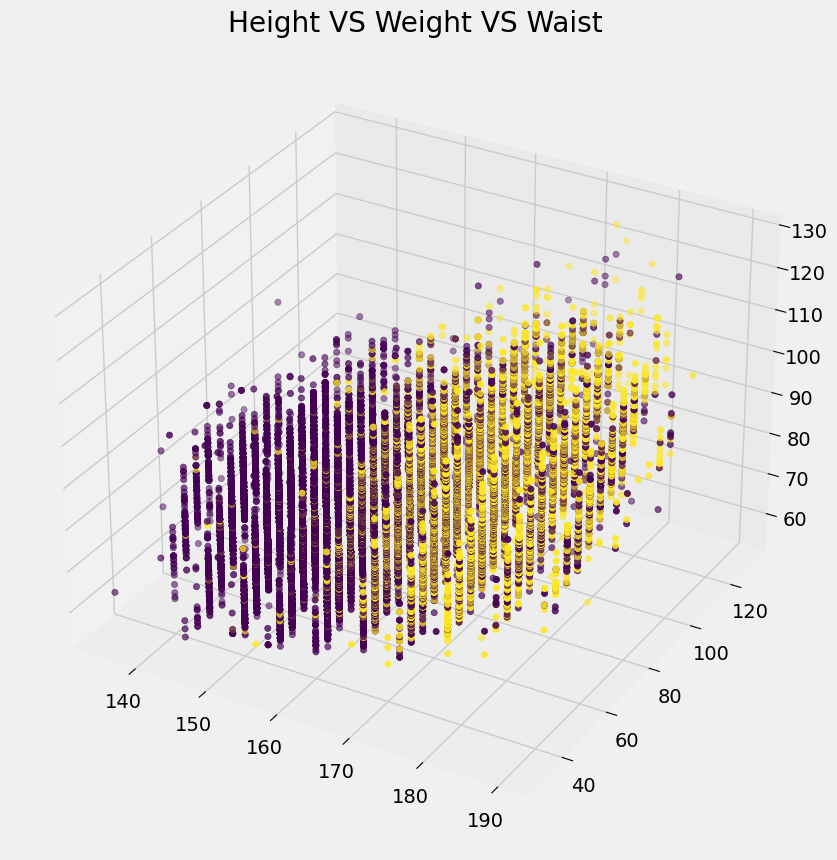

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.title("Height VS Weight VS Waist")

ax.scatter(data=train, xs=train["height(cm)"], ys=train["weight(kg)"], zs=train["waist(cm)"],
           c=train["smoking"])
plt.show()


Some Notable Insights:
*   These three variables could serves as a good predictor of gender via a clustering algorithm. (Possible Clustering Candidate)
*   We are seeing a mix of smoking and non-smoking instances in both clusters, however it seems more skewed to higher weights and waists



In [ ]:
gm = GaussianMixture(n_components=2, n_init=10)
fit_feats = ["weight(kg)", "height(cm)", "waist(cm)"]
subset = train[fit_feats]
gm.fit(subset)

GaussianMixture(n_components=2, n_init=10)

In [ ]:
def predict_and_add(data, feats, gm):
  subset = data[feats]
  pred = gm.predict_proba(subset)[:,0]
  pred = pd.DataFrame(pred, columns=["cluster_1"] )
  data =  pd.concat([data.reset_index(drop=True), pred.reset_index(drop=True)], axis='columns')
  return data

In [ ]:
train = predict_and_add(train, fit_feats, gm)
test = predict_and_add(test, fit_feats, gm)

In [ ]:
y = train['smoking']
X = train.drop(columns='smoking')

<BarContainer object of 23 artists>

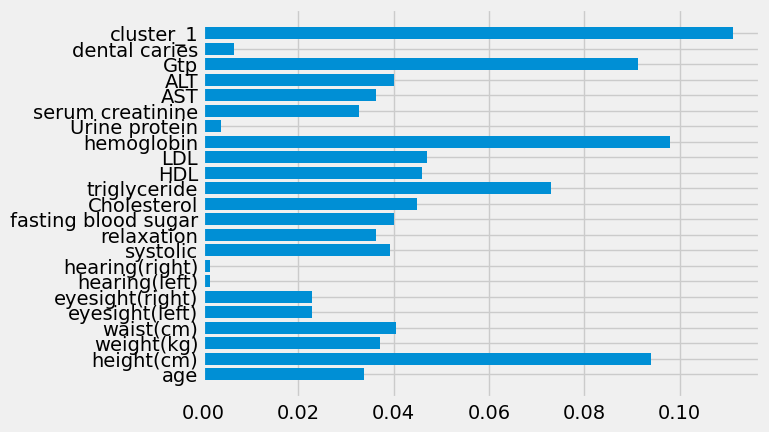

In [ ]:
#preliminary examination of feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X,y)
plt.barh([x for x in X.columns], rf.feature_importances_)

In [ ]:
rf.feature_importances_

array([0.03368482, 0.09385569, 0.03713902, 0.04055139, 0.02288968,
       0.02289062, 0.0014645 , 0.00154525, 0.03921975, 0.03627991,
       0.03999436, 0.04493748, 0.07293721, 0.04598485, 0.04695318,
       0.09794556, 0.00371129, 0.03265317, 0.03637243, 0.04000055,
       0.09120337, 0.00654515, 0.11124076])

In [ ]:
train.corr()['cluster_1'].drop(index=['height(cm)', 'weight(kg)',"waist(cm)", 'cluster_1']).sort_values(ascending=False).nlargest(3)

age            0.450568
HDL            0.390922
Cholesterol    0.098833
Name: cluster_1, dtype: float64

<h2>4. Feature Selection & Engineering </h2>

In [ ]:
train.drop(columns=['hearing(right)', "hearing(left)", 'dental caries', 'Urine protein'], inplace=True)

In [ ]:
train_pca = train[["Cholesterol", "LDL"]]
test_pca = test[["Cholesterol", "LDL"]]

pca = PCA(n_components=1)

train_pca = pca.fit_transform(train_pca)
test_pca = pca.fit_transform(test_pca)

<h2> 3. Preprocessing </h2>


In [ ]:
def power_transfo(data):
  non_cat_train = data.loc[:,data.nunique() > 20]
  cols = non_cat_train.columns
  pw = PowerTransformer(method='yeo-johnson')
  non_cat_train = pd.DataFrame(pw.fit_transform(non_cat_train), columns =
                        non_cat_train.columns)
  data.drop(columns=cols, inplace=True)
  data = pd.concat([data.reset_index(drop=True), non_cat_train.reset_index(drop=True)], axis='columns')
  return data


In [ ]:
#Feature crosses based on feature relationships seen in exploration
def crosses(data):

  data["bmi"] = data["weight(kg)"] / ((data["height(cm)"]/100)**2)
  data["systolic"] = pd.cut(x=data["systolic"], bins=[1,120,130,140, np.inf], labels=[0,1,2,3]).astype(int)
  data["relaxation"] = pd.cut(x=data["relaxation"], bins=[1,80,90, np.inf], labels=[0,2,3]).astype(int)
  data['h*g*t'] = data['hemoglobin'] * data['Gtp'] * data['triglyceride']

  return data

In [ ]:
def scaling(data):


  non_cat = data.loc[:, data.nunique() > 4]

  scl = StandardScaler()
  cat_scl = OneHotEncoder()

  cols = non_cat.columns
  data.drop(columns=non_cat, inplace=True)

  non_cat = pd.DataFrame(scl.fit_transform(non_cat), columns=cols)


  return pd.concat([data.reset_index(drop=True), non_cat.reset_index(drop=True)], axis='columns')


In [ ]:
train = crosses(train)
test = crosses(test)

In [ ]:
train = power_transfo(train)
test = power_transfo(test)

In [ ]:
y = train['smoking']
X = train.drop(columns='smoking')

In [ ]:
train.nunique()

age                       16
height(cm)                13
eyesight(left)            12
eyesight(right)           13
systolic                   4
relaxation                 3
serum creatinine           7
smoking                    2
weight(kg)                27
waist(cm)                503
fasting blood sugar       57
Cholesterol              172
triglyceride             279
HDL                       72
LDL                      161
hemoglobin                81
AST                       35
ALT                       51
Gtp                       80
cluster_1               8866
bmi                      153
h*g*t                  58434
dtype: int64

In [ ]:
X = scaling(X)
test=scaling(test)

In [ ]:
X.columns

Index(['systolic', 'relaxation', 'age', 'height(cm)', 'eyesight(left)',
       'eyesight(right)', 'serum creatinine', 'weight(kg)', 'waist(cm)',
       'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL',
       'hemoglobin', 'AST', 'ALT', 'Gtp', 'cluster_1', 'bmi', 'h*g*t'],
      dtype='object')

<h2> 4. Model Construction </h2>


In [ ]:
def display_scores(scores):
  print(scores)
  print('Mean: ', scores.mean())
  print('Std: ', scores.std())

In [ ]:
lg_clf = LogisticRegression(max_iter=1000)

for i in range(0, len(X.columns)):
  subset = X[X[rf.feature_importances_.nlargest(i).index]]
  scores = cross_val_score(lg_clf, X, y , cv=3, scoring='accuracy', verbose=0)
  display_scores(scores)

AttributeError: ignored

In [ ]:
display_scores(scores)

[0.75186583 0.75496855 0.75433962 0.75953878 0.76061889]
Mean:  0.7562663364267831
Std:  0.0032989274054864796
